# <center> Συστήματα Ανάκτησης Πληροφοριών </center>
## <center> Χειμερινό Εξάμηνο 2016-2017 || Προγραμματιστική Εργασία - Φάση 2 </center> 
### <center> Δημήτρης Παπαθεοδώρου 3130162 </center> 

## Γενικά
Σε αυτή τη φάση κληθήκαμε να συνεχίσουμε τη συλλογή πολιτικών tweets για τις κατηγορίες **#syriza**, **#neadimokratia**, **@tsipras**, **@mitsotakis** και να τα κατηγοριοποιήσουμε σε θετικά/αρνητικά αυτή τη φορά με βάση λεξικά, καθώς και να κάνουμε κάποιες περαιτέρω αναλύσεις για να εξορύξουμε στατιστικά δεδομένα, να κάνουμε κατηγοριοποίηση νέων όρων νέων όρων, κ.ά.

## Τεχνικά
Η ανάπτυξη της εφαρμογής έγινε σε Windows 8.1 σε **Python 3.5** του περιβάλλοντος __Anaconda__, που σημαίνει ότι είναι απαραίτητο το περιβάλλον __IPython__, καθώς και βιβλιοθήκες όπως __NumPy__, __SciPy__, __scikit-learn__, __pandas__. Επίσης, χρησιμοποιήθηκε το __PyCharm IDE__ και το __jupyter__ για τη συγγραφή του παρόντος ipython notebook. Η συλλογή των tweets έγινε μέσω του __tweepy__ κάνοντας χρήση του Twitter REST API και το DBMS που χρησιμοποιήθηκε ήταν **SQLite** μέσω του __sqlite3__ module.

## Scripts, Αρχεία και Δομή
Η εφαρμογή αποτελείται από python scripts που χωρίζονται σε δυο κατηγορίες:
1. τα backend modules που περιέχουν κλάσεις και συναρτήσεις που αποτελούν τον πυρήνα της λειτουργικότητας και λειτουργούν ως modules για την επίτευξη του στόχου. Αυτά είναι τα : **db**, **preprocessing**, **processing**
2. τα runnables που είναι εκτελέσιμα με την έννοια ότι αυτά είναι που τρέχουν τις απαραίτητες ρουτίνες για να εμφανιστούν τα αποτελέσματα. Αυτά είναι τα: **run_collect_tweets**, **run_tweet_classification**, **run_weekly_summary**, **run_term_classification**

Τα τελευταία έχουν dependencies στα πρώτα!

Επίσης, υπάρχει ένας φάκελος __resources__ που περιέχει τα λεξικά και τη λίστα με τα stopwords, κάποιοι φάκελοι **p_neighbors** που περιέχουν κάποια αρχεία που παράγονται στα τελευταία ερωτήματα της εργασίας και ο φάκελος **Weekly_Summary_Plots** που περιέχει τα plots που αφορούν ένα ερώτημα σε png αρχεία.

Τέλος, η βάση βρίσκεται στο **pypolDB.db**.

---

## Βάση Δεδομένων
Διατήρηθηκε η χρήση της SQLite απ΄την προηγούμενη φάση της εργασίας για τον ίδιο λόγο. Είναι απλή, αρκετή για το scaling της εφαρμογής και μεταφέρεται εύκολα καπώς είναι απλά ένα αρχείο.

Το σχήμα της βάσης pypolDB αποτελείται από 2 απλούς πίνακες:
* **Tweets** που αποθηκεύει τα tweets μετά την προεπεξεργασία με στήλες:
  * id: το id του tweet
  * text: το ακαθάριστο κείμενο του tweet
  * clean_text: το κείμενο του tweet μετά τον καθαρισμό
  * category: η κατηγορία που ανήκει με βάση το hashtag
  * date: η ημερομηνία του tweet σε μορφή YY-MM-DD
  * class: η κλάση που ανήκει το tweet, Positive ή Negative
    * Πρωτεύον κλειδί {id, category}, γιατί μπορεί ένα tweet να περιέχει hashtags από πολλές κατηγορίες και το text πεδίο unique, ώστε να αγνοούνται τα διπλότυπα.
  
* **Stats** με τα ημερήσια στατιστικά των tweets με στήλες:
  * category
  * positive
  * negative
  * date
    * Πρωτεύον κλειδί {category, date}
    
---

## Βασικά modules
Παρακάτω ακολουθεί και επεξηγείται ο κώδικας των βασικών backend modules που αναφέρθηκαν πιο πάνω. Αυτά τα modules πρέπει να τρέξουν πριν ακολουθήσουν τα επόμενα.

### db.py - Επικοινωνία με τη βάση δεδομένων

Οι συναρτήσεις είναι απλές και λειτουργούν ως ένα μικρό επίπεδο αφαίρεσης πάνω απ΄τις βασικές εντολές του sqlite3.
Η _insert_ δέχεται ένα dictionary με κλειδιά τα γνωρίσματα της βάσης και τιμές τις λίστες με τα δεδομένα κι εντός της insert από column-oriented μετατρέπεται σε μια λίστα από λίστα προσομοιώνοντας ένα 2d-array, δηλαδή σε μια λίστα από εγγραφές για τη βάση.
Εάν το καθαρισμένο κείμενο μιας εγγραφής είναι κενό, τότε σημαίνει ότι απ΄τον καθαρισμό του δεν έμεινε χρήσιμο φορτίο, οπότε αγνοείται.

In [1]:
import sqlite3 as lite

con = None

def connect():
    global con
    con = lite.connect('pypolDB.db')

def create():
    global con
    with con:
        cur = con.cursor()
        cur.execute(
            "CREATE TABLE IF NOT EXISTS Tweets(id INT, text TEXT, clean_text TEXT, category TEXT,"
            "date TEXT, class INT, PRIMARY KEY (id, category), UNIQUE(text) ON CONFLICT IGNORE)")
        cur.execute(
            "CREATE TABLE IF NOT EXISTS Stats(category TEXT, positive TEXT, negative TEXT, date TEXT,"
            "PRIMARY KEY(category, date) ON CONFLICT IGNORE)")

# tweets is a dict
def insert(tweets):
    global con
    with con:
        cur = con.cursor()
        tweets_arr = []
        for i in range(len(tweets['id'])):
            if tweets['clean_text'][i].strip() == "":
                continue  # no greek text -> throw away
            tweets_arr.append([tweets['id'][i], tweets['text'][i], tweets['clean_text'][i], tweets['category'][i],
                               tweets['date'][i], tweets['class'][i]])
        cur.executemany("INSERT OR IGNORE INTO Tweets VALUES(?, ?, ?, ?, ?, ?)", tweets_arr)

def insert_stats(stats):
    global con
    with con:
        cur = con.cursor()
        cur.executemany("INSERT OR IGNORE INTO Stats VALUES(?, ?, ?, ?)", stats)

def select(query):
    global con
    with con:
        cur = con.cursor()
        cur.execute(query)
        return cur.fetchall()

### preprocessing.py - Προεπεξεργασία δεδομένων
Εδώ γίνεται η προεπεξεργασία των tweets μέσω ενός custom made Greek Analyzer που καθαρίζει το κείμενο των tweets από υπερσυνδέσμους, λατινικούς χαρακτήρες, ειδικούς χαρακτήρες, σημεία στίξης, tags κι έπειτα αφαίρει τα stopwords και κάνει stemming. Πρόκειται για προσαρμογή του δοθέντος greek stemmer που ήταν σε java.

#### GreekAnalyzer
Χρησιμοποιώντας μια εσωτερική κλάση αναπαράστασης μιας συμβολοσειράς, Sentence, μπορούσα στην clean συνάρτηση να καλώ την αλληλουχία των συναρτήσεων που καθαρίζουν το κείμενο προσομοιώνοντας ένα stream.

In [4]:
import re
import unicodedata

class GreekAnalyzer:
    one_suff = ('Α', 'Ο', 'Ε', 'Η', 'Ω', 'Υ', 'Ι')
    three_suff = ('ΟΥΣ', 'ΕΙΣ', 'ΕΩΝ', 'ΟΥΝ')
    two_suff = ('ΟΣ', 'ΗΣ', 'ΕΣ', 'ΩΝ', 'ΟΥ', 'ΟΙ', 'ΑΣ', 'ΩΣ', 'ΑΙ', 'ΥΣ', 'ΟΝ', 'ΑΝ', 'ΕΙ')

    class Sentence:
        # This class represents a string which will be cleaned as part of a pre-processing procedure
        def __init__(self, sentence):
            self.sentence = str(sentence).upper()

        def __repr__(self):
            return str(self.sentence)

        # Default argument values are evaluated at function define-time,
        # but self is an argument only available at function call time.
        # Thus arguments in the argument list cannot refer each other.

        def strip_accents(self, sentence=None):
            if sentence is None:
                sentence = self.sentence
            return GreekAnalyzer.Sentence(''.join(c for c in unicodedata.normalize('NFD', sentence)
                                                  if unicodedata.category(c) != 'Mn'))

        def strip_specialcharacters_numbers(self, sentence=None):
            if sentence is None:
                sentence = self.sentence
            return GreekAnalyzer.Sentence(re.sub(r'[^Α-Ωα-ω ]', '', sentence, flags=re.MULTILINE))

        def strip_links(self, sentence=None):
            if sentence is None:
                sentence = self.sentence
            return GreekAnalyzer.Sentence(re.sub(r'^https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE))

        def strip_tags(self, sentence=None):
            if sentence is None:
                sentence = self.sentence
            return GreekAnalyzer.Sentence(re.sub(r'#\w*|@\w*', '', sentence, flags=re.MULTILINE))

        def stem(self, sentence=None):
            if sentence is None:
                sentence = self.sentence
            stemmed = ""
            for term in sentence.split():
                # Check if term is numeric
                pattern = re.compile("^[+-]?(\\d+(\\.\\d*)?|\\.\\d+)([eE][+-]?\\d+)?$")
                if pattern.match(term):
                    return ''
                # Remove first level suffixes only if the term is 4 letters or more
                if len(term) >= 4:
                    # Remove the 3 letter suffixes
                    if term.endswith(GreekAnalyzer.three_suff):
                        term = term[:-3]
                        # Remove the 2 letter suffixes
                    elif term.endswith(GreekAnalyzer.two_suff):
                        term = term[:-2]
                    # Remove the 1 letter suffixes
                    elif term.endswith(GreekAnalyzer.one_suff):
                        term = term[:-1]
                stemmed += term + ' '
            # return GreekAnalyzer.Sentence(stemmed[:-1])
            return GreekAnalyzer.Sentence(stemmed[:-1])

        def strip_stopwords(self, sentence=None, stop_words=None):
            if sentence is None:
                sentence = self.sentence
            if stop_words is None:
                return GreekAnalyzer.Sentence(sentence)
            for w in stop_words:
                sentence = re.sub(r'\b'+w+r'\b', '', sentence)
            return GreekAnalyzer.Sentence(sentence)

    def __init__(self, sentence):
        if isinstance(sentence, GreekAnalyzer.Sentence):
            self.sentence = sentence
        else:
            self.sentence = GreekAnalyzer.Sentence(sentence)

    def clean(self, sentence=None, stop_words=None):
        if sentence is None:
            sentence = self.sentence
        if isinstance(sentence, GreekAnalyzer.Sentence):
            return str(sentence
                       .strip_accents()
                       .strip_links()
                       .strip_tags()
                       .strip_specialcharacters_numbers()
                       .strip_stopwords(stop_words=stop_words).stem()
                       )
        else:
            return GreekAnalyzer(GreekAnalyzer.Sentence(sentence)).clean(stop_words)

Επιπλέον συναρτήσεις του preprocessing module:
Φορτώνει τα stopwords σε μια global μεταβλητή και διαθέτει μια συνάρτηση *clean\_tweets* που δέχεται ένα dictionary από tweets, καθαρίζει το κείμενό τους με τον GreekAnalyzer, προσθέτει τα καθαρισμένα κείμενα στο κλειδί clean_text κι επιστρέφει το ανανεωμένο dictionary και μια συνάρτηση *format\_time* που μετατρέπει ημερομηνίες της μορφής 2012-5-9 σε 2012-05-09, γιατί βολεύει κατά το ordering που γίνεται στην πορεία στη βάση. 

In [5]:
fstopwords = open('resources\greekstopwords.txt', 'rt', encoding="utf8")

stopwords = [w.strip() for w in fstopwords.readlines() if w.strip() != '']
del (stopwords[0])  # for some reason it's a garbage word

fstopwords.close()

def clean_tweets(tweets: dict):
    proc = []
    for text in tweets['text']:
        analyzer = GreekAnalyzer(text)
        proc.append(analyzer.clean(stop_words=stopwords))
    tweets['clean_text'] = proc
    return tweets

def format_time(time):
    strtime = str(time)
    digits = len(strtime)
    if digits == 1:
        return "0"+strtime
    else:
        return strtime


### processing.py - Επεξεργασία Δεδομένων
Εδώ φορτώνονται τα λεξικά και υλοποιείται το classification των tweets και των terms, το μεν με τη συνάρτηση _classify_ και το δε με την κλάση TermClassifier.

Αρχικά φορτώνονται τα λεξικά. Αυτό γίνεται κρατώντας μόνο το επεξεργασμένο μέρος των λέξεων που είναι κεφαλαίο και stemmed, καθώς σε αυτή τη φάση τα κείμενά μας έχουν περάσει κι αυτά προεπεξεργασία.

In [7]:
import numpy as np
import pandas as pd
import csv
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
import os

import warnings
warnings.filterwarnings("ignore")

fposlex = open('resources\PosLex.csv', 'rt', encoding="utf8")
fneglex = open('resources\\NegLex.csv', 'rt', encoding="utf8")

def populate_lex(file):
    lex = []
    reader = csv.reader(file)
    next(reader, None)  # skip first line
    for row in reader:
        if row[2] not in lex:  # using a set would be a solution, but it requires conversion to list
            lex.append(row[2])
    return lex

poslex = populate_lex(fposlex)
neglex = populate_lex(fneglex)
fposlex.close()
fneglex.close()

Η κατηγοριοποίηση των tweets γίνεται με την εξής μεθοδολογία:
Δημιουργούνται 2 CountVectorizers fit με τα καθαρισμένα κείμενα, ο ένας με vocabulary το θετικό λεξικό κι ο άλλος το αρνητικό.
Με την toarray() επιστρέφεται ένας πίνακας documents _x_ terms, όπου σε κάθε κελί βρίσκεται η συχνότητα εμφάνισης ενός όρου σε ένα κείμενο. Λόγω των λεξικών, οι όροι που εμφανίζονται είναι αυτοί των λεξικών. Επομένως σε κάθε στήλη των πινάκων αναπαριστά ένα κείμενο σε έναν διανυσματικό χώρο που ορίζουν οι λέξεις των λεξικών. Έτσι, προσθέτοντας την τιμή κάθε συνιστώσας βρίσκουμε το "πόσο θετικό" ή "πόσο αρνητικό" είναι ένα κείμενο. Εάν η διαφορά της θετικότητας πλην της αρνητικότητας είναι θετική, τότε κατατάσσεται ως θετικό, αν είναι μικρότερη τότε ως αρνητικό. Με απλά λόγια, εάν περιέχει περισσότερες θετικές λέξεις απ΄ότι αρνητικές, είναι θετικό, αλλιώς αρνητικό. Εάν η διαφορά είναι 0, τότε επιλέγεται μια κατηγορία τυχαία.

Πιθανότατα εδώ θα μπορούσε να γίνει κάποια κανονικοποίηση καθώς το αρνητικό λεξικό είναι πολύ μεγαλύτερο του θετικού, αλλά ακολούθησα την εκφώνηση.

In [8]:
def classify(tweets, categories):
    tdf = pd.DataFrame(tweets)
    texts = tdf['clean_text']
    cv_pos = CountVectorizer(input='content', vocabulary=poslex, decode_error='ignore', lowercase=False)
    X_pos = cv_pos.fit_transform(texts).toarray()
    cv_neg = CountVectorizer(input='content', vocabulary=neglex, decode_error='ignore', lowercase=False)
    X_neg = cv_neg.fit_transform(texts).toarray()
    sentiment = []
    for irow in range(X_pos.shape[0]):
        prow = X_pos[irow, :]
        nrow = X_neg[irow, :]
        tsentiment = np.sum(prow) - np.sum(nrow)
        if tsentiment > 0:
            sentiment.append("Positive")
        elif tsentiment < 0:
            sentiment.append("Negative")
        else:
            sentiment.append(random.choice(['Positive', 'Negative']))
    tweets['class'] = sentiment
    return tweets

#### TermClassifier
Ο TermClassifier είναι ο κατηγοριοποιητής των όρων με βάση τις οδηγίες της εκφώνησης.
Έχει ως πεδία έναν CountVectorizer αυτή τη φορά με vocabulary όσους όρους εμφανίζονται σε 2 κείμενα τουλάχιστον (min_df=2), τον τον πίνακα U του SVD σε μειωμένες διαστάσεις, συγκεκριμένα rank διαστάσεις που δίνονται ως όρισμα. Ο πίνακας που επιστρέφει το cv.fit\_transform(X) είναι documents _x_ terms, οπότε τον κάνουμε transpose σε terms _x_ documents.

Με τη *normalize\_terms* κανονικοποιούμε τις γραμμές ενός πίνακα με την ευκλείδια νόρμα και εδώ συγκεκριμένα τη χρησιμοποιούμε για τον πίνακα U. Εάν η νόρμα είναι μηδενική, τότε βάζουμε 0.
Για τη μετρική της απόστασης προτιμήθηκε το cosine similarity.
Η *get\_closest\_neighbors* δοθέντος ενός όρου βρίσκει τους κατά cosine similarity n\_neighbors κοντινότερους όρους σε αυτήν, πλην του ίδιου της του εαυτού φυσικά.
Η *get\_terms\_svd* κάνει SVD σε έναν πίνακα και επιστρέφει τον U σε μειωμένη διάσταση.

Η *classify\_terms* είναι η βασική μέθοδος της κλάσης. Για κάθε όρο που ανήκει σε κάποιο λεξικό, βρίσκει τους n_neighbors κοντινότερους γείτονές της, εκμεταλλευόμενη τα indices των terms στον πίνακα U και στον πίνακα που επιστρέφει η get_features_names() του CountVectorizer που παραμένουν ίδια άρα αντιστοιχίζεται εύκολα το πραγματικό όνομα με τη διανυσματική αναπαράσταση, και τους εγγράφει σε ένα αρχείο ExtPos(term) αν είναι θετικός όρος ή ExtNeg(term) αν είναι αρνητικός. Έτσι, χαρακτηρίζουμε αυτούς τους γείτονες θετικούς ή αρνητικούς αναλόγως με αν κατατάχθηκαν σε θετικό ή σε αρνητικό αρχείο. Όλα αυτά τα αρχεία μπαίνουν σε φάκελο p\_neighbors (p = n\_neighbors), ώστε κάθε φορά που τρέχει ο αλγόριθμος με διαφορετικό n\_neighbors, να έχουμε διαφορετικό directory με τα αποτελέσματα.
Επίσης, τυπώνει το μέσο όρων των ήδη γνωστών μέσω των λεξικών όρων για θετικούς και αρνητικούς, καθώς και νέους όρους που συναντήσαμε και έγιναν classify.

In [52]:
class TermClassifier:

    def __init__(self, X, rank):
        self.cv = CountVectorizer(input='content', decode_error='ignore', lowercase=False, min_df=2)
        self.U_terms = self.get_terms_svd(self.cv.fit_transform(X).toarray().T, rank)

    def normalize_terms(self, U):
        normalized = []
        for row in U:
            norm = np.linalg.norm(row)
            if norm == 0:
                normalized.append([0 for _ in row])
            else:
                normalized.append([cell/norm for cell in row])
        return normalized

    def distance(self, a, b):
        return cosine_similarity(a, b)

    def get_terms_svd(self, X, rank=300):
        U, S, V = np.linalg.svd(np.array(X), full_matrices=False)
        return self.normalize_terms(U[:, :rank])

    def get_closest_neighbors(self, term, index, n_neighbors):
        distances = []
        for i in range(len(self.U_terms)):
            x = self.U_terms[i]
            if index == i:
                distances.append(-99999)
                continue  # it's it self
            distances.append(cosine_similarity(x, term))
        return np.argpartition(distances, -n_neighbors)[-n_neighbors:]

    def classify_terms(self, n_neighbors):
        dir = str(n_neighbors) + '_neighbors\\'
        ext_pos = {}
        ext_neg = {}
        pos_sum = 0
        neg_sum = 0
        new_pos = set()
        new_neg = set()

        terms = self.cv.get_feature_names()
        t = 0
        for u_term in self.U_terms:
            term = terms[t]
            sentiment = 0
            if term in poslex:
                sentiment = 1
            elif term in neglex:
                sentiment = -1
            else:
                t += 1
                continue

            idx = self.get_closest_neighbors(u_term, t, n_neighbors)
            neighs = [terms[i] for i in idx]

            if sentiment == 1:
                ext_pos[term] = neighs
                filename = dir + 'ExtPos(' + term + ').txt'
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, "w", encoding='utf-8') as f:
                    for tn in neighs:
                        f.write(tn+"\n")
            else:
                ext_neg[term] = neighs
                filename = dir + 'ExtNeg(' + term + ').txt'
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, "w", encoding='utf-8') as f:
                    for tn in neighs:
                        f.write(tn+"\n")
            t += 1
        # end for loop
        for term, neighbors in ext_pos.items():
            for n in neighbors:
                if n in poslex:
                    pos_sum += 1
                else:
                    new_pos.add(n)
        for term, neighbors in ext_neg.items():
            for n in neighbors:
                if n in neglex:
                    neg_sum += 1
                else:
                    new_neg.add(n)
        pos_all = len(ext_pos)
        neg_all = len(ext_neg)
        pos_mean = pos_sum / pos_all
        neg_mean = neg_sum / neg_all
        print("\n\n--- Based on nearest %d neighbors classification ---" % n_neighbors)
        print("Mean value of already known positive terms: ", pos_mean)
        print("Mean value of already known negative terms: ", neg_mean)
        print("\n~~~~~Newly found positive terms:")
        for pterm in new_pos:
            print(pterm, end=",  ")
        print("\n\n~~~~~Newly found negative terms:")
        for nterm in new_neg:
            print(nterm, end=",  ")

---
### Scripts προς εκτέλεση
Παρακάτω παρατίθενται τα scripts που εκτελούν τις διάφορες λειτουργικότητες του project.

### run_collect_tweets.py - Συλλογή Tweets
Διατηρήθηκε η ίδια τακτική με την προηγούμενη εργασία. Twitter REST API σε loop με scheduler, ώστε να συλλέγονται συνεχώς tweets και να αποφεύγεται rate limit exceeded error.
Επιπλέον tweets κάθε κατηγορίας συλλέγονται από διαφορετικό search ώστε ευθύς αμέσως να συμπληρώνεται η κατηγορία τους στο dictionary με τα tweets. Απ΄την ημερομηνία συγκρατείται ο χρόνος, ο μήνας και η ημέρα σε μορφή YYYY-MM-DD (τα μονοψήφια γίνονται διψήφια με προσθήκη μηδενικού στις δεκάδες).
Τα tweets καθαρίζονται, κατηγοριοποιούνται σε αρνητικά/θετικά και αποθηκεύονται στη βάση.

In [12]:
import sched
import time
import tweepy

import preprocessing
import processing
import db

consumer_key = 'YRnp0q7lSJLRU1KFzXzfQpgBj'
consumer_secret = '1GrTLHR67JMjqh1jzeHzfZEwesEGTI8WMkH5IlrvEKzw5VKXWl'
access_token = '157119280-8DPkm3KENaA7rrBbhk52PizQL8gKIGnS4q1crk5o'
access_token_secret = 'v6XmeY9PwfyIBf85dvud31e3GfJCM5VaaqnmTL7nhhONx'

oauth = tweepy.OAuthHandler(consumer_key, consumer_secret)
oauth.set_access_token(access_token, access_token_secret)

api = tweepy.API(oauth)

db.connect()
db.create()

last_id = {'#syriza': 0, '#neadimokratia': 0, '@tsipras': 0, '@mitsotakis': 0}
loops = 0

schedule = sched.scheduler(time.time, time.sleep)

def get_tweets():
    global last_id, loops
    print("Let's collect some tweets!")
    tweets = {'id': [], 'text': [], 'clean_text': [], 'category': [], 'date': []}

    while True:
        try:
            new_tweets = []
            cur = None

            search_res = api.search(q='#syriza -rt',  max_id=str(last_id['#syriza'] - 1), count=100)
            for t in search_res:
                new_tweets.append((t, '#syriza'))
                cur = t
            last_id_syriza = 0 if cur is None else cur.id

            search_res = api.search(q='#neadimokratia -rt', max_id=str(last_id['#neadimokratia'] - 1), count=100)
            for t in search_res:
                new_tweets.append((t, '#neadimokratia'))
                cur = t
            last_id_nd = 0 if cur is None else cur.id

            search_res = api.search(q='@tsipras -rt', max_id=str(last_id['@tsipras'] - 1), count=100)
            for t in search_res:
                new_tweets.append((t, '@tsipras'))
                cur = t
            last_id_tsipras = 0 if cur is None else cur.id

            search_res = api.search(q='@mitsotakis -rt', max_id=str(last_id['@mitsotakis'] - 1), count=100)
            for t in search_res:
                new_tweets.append((t, '@mitsotakis'))
                cur = t
            last_id_mitsotakis = 0 if cur is None else cur.id

            loops += 1
            print(len(new_tweets), "new tweets")
            if not new_tweets:
                print("No new tweets")
                if loops > 15:
                    last_id['#syriza'] = 0
                    last_id['#neadimokratia'] = 0
                    last_id['@tsipras'] = 0
                    last_id['@mitsotakis'] = 0
                    loops = 0
                schedule.enter(60, 1, get_tweets, ())
                # a minute delay so it won't abuse the limit if not new tweets are there
                break
            else:
                for t in new_tweets:
                    if t[0].id not in tweets['id']:
                        # checking for duplicates here load-balances the overhead
                        tweets['id'].append(t[0].id)
                        tweets['text'].append(t[0].text)
                        tweets['category'].append(t[1])
                        ttime = t[0].created_at
                        tweets['date'].append('%s-%s-%s' % (str(ttime.year),
                                                            preprocessing.format_time(ttime.month),
                                                            preprocessing.format_time(ttime.day)))
                last_id['#syriza'] = last_id_syriza
                last_id['#neadimokratia'] = last_id_nd
                last_id['@tsipras'] = last_id_tsipras
                last_id['@mitsotakis'] = last_id_mitsotakis
        except tweepy.TweepError as e:
            print("Error: ", str(e))
            if 'Rate limit exceeded' in str(e):
                last_id['#syriza'] = 0
                last_id['#neadimokratia'] = 0
                last_id['@tsipras'] = 0
                last_id['@mitsotakis'] = 0
                schedule.enter(60*15+1, 1, get_tweets, ())
                loops = 0
            else:
                schedule.enter(1, 1, get_tweets, ())
            break

    if tweets:
        tweets = preprocessing.clean_tweets(tweets)
        tweets = processing.classify(tweets, ('#syriza', '#neadimokratia', '@tsipras', '@mitsotakis'))
        db.insert(tweets)
        tweets.clear()

schedule.enter(0, 1, get_tweets, ())
schedule.run()

Let's collect some tweets!
139 new tweets
100 new tweets
116 new tweets
100 new tweets
58 new tweets
0 new tweets
No new tweets
Let's collect some tweets!
0 new tweets
No new tweets


KeyboardInterrupt: 

### run_term_stats.py - Αποθήκευση ημερήσιων στατιστικών στη βάση
Εδώ τα δεδομένα ανακτώνονται ομαδοποιημένα κατά date, category, class με βάση το πλήθος, δηλαδή έχουμε το πλήθος των θετικών κι αρνητικών tweets ανά κατηγορία και ανά μέρα.
Μετατρέπουμε τα δεδομένα σε ένα πολυεπίπεδο dictionary και έπειτα σε flat map για αποθηκευτούν στη βάση.

In [14]:
import copy
import db

db.connect()
data = db.select("SELECT date, category, class, count(*) FROM Tweets GROUP BY date, category, class")

datadict_template = {'#neadimokratia': {'Positive': 0, 'Negative': 0},
                     '#syriza': {'Positive': 0, 'Negative': 0},
                     '@tsipras': {'Positive': 0, 'Negative': 0},
                     '@mitsotakis': {'Positive': 0, 'Negative': 0}}
datadict = copy.deepcopy(datadict_template)
datedatadict = {}
prev_date = data[0][0]
for row in data:
    if row[0] != prev_date:
        datedatadict[prev_date] = datadict
        datadict = copy.deepcopy(datadict_template)
    datadict[row[1]][row[2]] = row[3]
    prev_date = row[0]

final_data = []
for date in datedatadict:
    for cat in datedatadict[date]:
        catdict = datedatadict[date][cat]
        final_data.append([cat, catdict['Positive'], catdict['Negative'], date])

db.insert_stats(final_data)
print('Done ;)')

Done ;)


### run_weekly_summary.py - Εβδομαδιαία σύνοψη στατιστικών
Ανακτώνται ταξινομημένα με βάση την ημερομηνία τα δεδομένα του Stats και ομαδοποιούνται σε εβδομάδες, δηλαδή ανά 7 μέρες και αποηθηκεύονται σε ένα pandas DataFrame αντικείμενο. Αυτό μας επιτρέπει να κάνουμε εύκολα και γρήγορα ομαδοποιήσεις δεδομένων και να παράξουμε στατιστικά από αυτά τα aggregations σε έναν όμορφο πίνακα. Στο notebook ο πίνακας φαίνεται πιο όμορφος απ΄ότι στην κονσόλα :D

Επιπλέον, για κάθε βδομάδα εμφανίζεται ένα plot με άξονα _x_ τις 7 ημέρες και άξονα _y_ τα θετικά και αρνητικά tweets. Οι γραμμές άνω του άξονα _x_, δηλαδή με θετικό πρόσημο, δείχνουν το πλήθος των θετικών tweets και αναπαρίστανται με συνεχείς γραμμές, ενώ οι γραμμές κάτω του είναι το πλήθος των αρνητικών και αναπαρίστανται με διακεκομμένες.
Τα χρώματα στις κατηγορίες είναι:
#syriza: κόκκινο || #neadimokratia: μπλε || @tsirpas: μαύρο || @mitsotakis: κυανό

! Ο παρακάτω κώδικας είναι τροποποιημένος σε σχέση με του αρχείου, για να δουλέψει σωστά στο notebook.

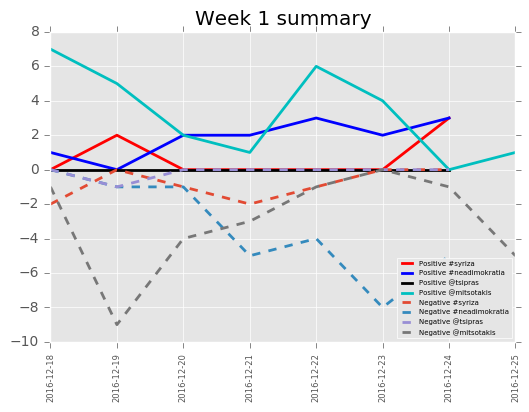

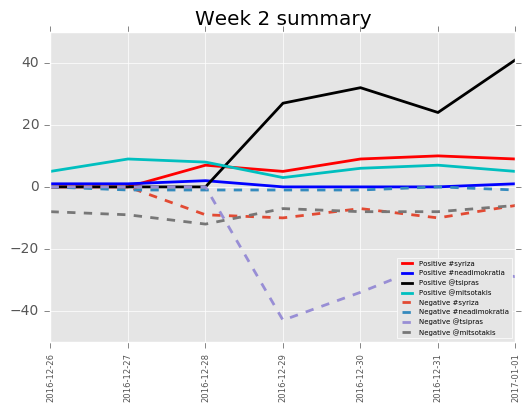

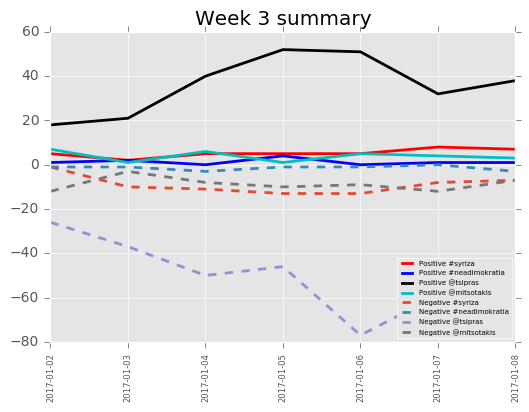

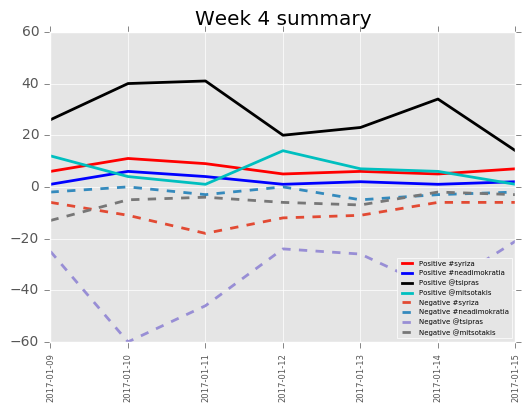

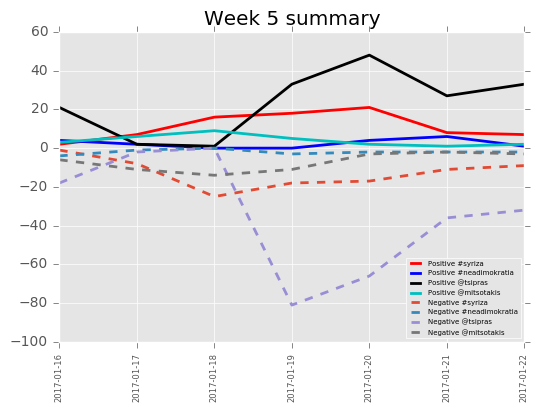

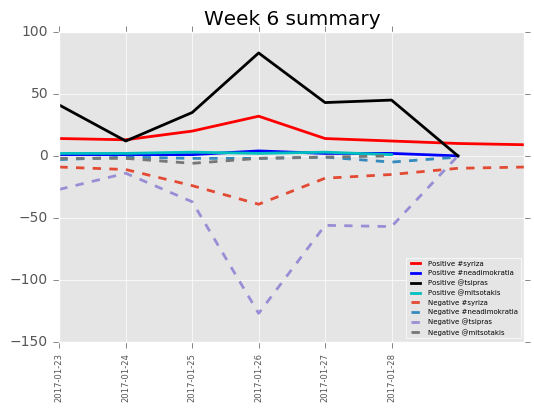

In [1]:
from sklearn.preprocessing import LabelEncoder

import db
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
matplotlib.style.use('ggplot')

db.connect()
stats = db.select('SELECT date, category, positive, negative FROM Stats ORDER BY date')

last_day = stats[-1][0]

days = 0
week_num = 1
prev_date = stats[0][0]
weeks = []
istats = []

for row in stats:
    if row is stats[-1]:
        days = 6
    if days == 7:
        days = 0
        week_num += 1
    istats.append([row[0], row[1], int(row[2]), int(row[3])])
    if row[0] > prev_date:  # new day
        days += 1
    prev_date = row[0]
    weeks.append(week_num)

df = pd.DataFrame(istats)
df.columns = ['Date', 'Category', 'Positive', 'Negative']
df['Week'] = weeks
grouped = df[['Week', 'Category', 'Positive', 'Negative']].groupby(['Week', 'Category'])
wstats_toshow = grouped.agg([np.sum, np.average, np.std])
wstats = grouped.agg([np.sum, np.average, np.std]).reset_index()

# plot please
for w in range(1, np.max(df['Week'])):
    dfp = df.query('Week == %d' % w)[['Date', 'Category', 'Positive', 'Negative']]
    legend = []
    le = LabelEncoder()
    fig, ax = plt.subplots(1, 1)
    for sent in [('Positive', 1), ('Negative', -1)]:
        for cat in [('#syriza', 'r'), ('#neadimokratia', 'b'), ('@tsipras', 'k'), ('@mitsotakis', 'c')]:
            dfcat = dfp[dfp.Category == cat[0]]
            le.fit(dfcat['Date'])
            plt.xticks(le.transform(dfcat['Date']), dfcat['Date'], rotation='vertical', fontsize=6)
            dfcat['Date'] = le.transform(dfcat['Date'])
            lstyle = cat[1] + '-' if sent[1] == 1 else '--'
            plt.plot(dfcat['Date'], sent[1]*dfcat[sent[0]], lstyle, linewidth=2)
            plt.title("Week %d summary" % w)
            legend.append(sent[0] + " " + cat[0])
    plt.legend(legend, prop={'size': 5}, loc=4)
    # fig_man = plt.get_current_fig_manager()
    # fig_man.window.showMaximized()
plt.tight_layout
plt.show()

In [46]:
wstats_toshow  # στατιστικ΄η σύνοψη

Positive                       Negative             \
                         sum    average        std      sum    average   
Week Category                                                            
1    #neadimokratia       13   1.857143   1.069045       24   3.428571   
     #syriza               5   0.714286   1.253566        6   0.857143   
     @mitsotakis          26   3.250000   2.604940       24   3.000000   
     @tsipras              0   0.000000   0.000000        1   0.142857   
2    #neadimokratia        5   0.714286   0.755929        5   0.714286   
     #syriza              40   5.714286   4.231402       42   6.000000   
     @mitsotakis          43   6.142857   2.035401       58   8.285714   
     @tsipras            124  17.714286  17.384996      130  18.571429   
3    #neadimokratia        9   1.285714   1.380131       10   1.428571   
     #syriza              37   5.285714   1.889822       63   9.000000   
     @mitsotakis          27   3.857143   2.340126       61   8.714286   
     @tsipras            252  36.000000  13.329166      341  48.714286   
4    #neadimokratia       17   2.428571   1.902379       15   2.142857   
     #syriza              49   7.000000   2.236068       70  10.000000   
     @mitsotakis          45   6.428571   5.061526       40   5.714286   
     @tsipras            198  28.285714  10.307187      242  34.571429   
5    #neadimokratia       17   2.428571   2.299068       14   2.000000   
     #syriza              79  11.285714   7.016986       89  12.714286   
     @mitsotakis          28   4.000000   2.828427       50   7.142857   
     @tsipras            165  23.571429  17.164471      235  33.571429   
6    #neadimokratia       11   1.571429   1.272418       15   2.142857   
     #syriza             124  15.500000   7.445037      135  16.875000   
     @mitsotakis          13   2.166667   0.752773       13   2.166667   
     @tsipras            259  37.000000  26.551836      318  45.428571   
7    #neadimokratia        3   0.428571   0.786796        6   0.857143   
     #syriza              76  12.666667   7.941452      111  18.500000   
     @mitsotakis           2   0.285714   0.487950        7   1.000000   
     @tsipras              1   0.142857   0.377964        1   0.142857   

                                
                           std  
Week Category                   
1    #neadimokratia   2.878492  
     #syriza          0.899735  
     @mitsotakis      2.976095  
     @tsipras         0.377964  
2    #neadimokratia   0.487950  
     #syriza          4.358899  
     @mitsotakis      1.889822  
     @tsipras        18.292595  
3    #neadimokratia   1.133893  
     #syriza          4.203173  
     @mitsotakis      3.147183  
     @tsipras        16.204056  
4    #neadimokratia   1.772811  
     #syriza          4.434712  
     @mitsotakis      3.638419  
     @tsipras        14.535670  
5    #neadimokratia   1.290994  
     #syriza          7.889112  
     @mitsotakis      4.810702  
     @tsipras        30.756339  
6    #neadimokratia   1.463850  
     #syriza         10.357020  
     @mitsotakis      2.041241  
     @tsipras        41.556617  
7    #neadimokratia   1.069045  
     #syriza          5.128353  
     @mitsotakis      1.000000  
     @tsipras         0.377964

In [49]:
df.groupby(['Week', 'Category']).describe() # more stats

Negative   Positive
Week Category                                  
1    #neadimokratia count   7.000000   7.000000
                    mean    3.428571   1.857143
                    std     2.878492   1.069045
                    min     0.000000   0.000000
                    25%     1.000000   1.500000
                    50%     4.000000   2.000000
                    75%     5.000000   2.500000
                    max     8.000000   3.000000
     #syriza        count   7.000000   7.000000
                    mean    0.857143   0.714286
                    std     0.899735   1.253566
                    min     0.000000   0.000000
                    25%     0.000000   0.000000
                    50%     1.000000   0.000000
                    75%     1.500000   1.000000
                    max     2.000000   3.000000
     @mitsotakis    count   8.000000   8.000000
                    mean    3.000000   3.250000
                    std     2.976095   2.604940
                    min     0.000000   0.000000
                    25%     1.000000   1.000000
                    50%     2.000000   3.000000
                    75%     4.250000   5.250000
                    max     9.000000   7.000000
     @tsipras       count   7.000000   7.000000
                    mean    0.142857   0.000000
                    std     0.377964   0.000000
                    min     0.000000   0.000000
                    25%     0.000000   0.000000
                    50%     0.000000   0.000000
...                              ...        ...
7    #neadimokratia std     1.069045   0.786796
                    min     0.000000   0.000000
                    25%     0.000000   0.000000
                    50%     1.000000   0.000000
                    75%     1.000000   0.500000
                    max     3.000000   2.000000
     #syriza        count   6.000000   6.000000
                    mean   18.500000  12.666667
                    std     5.128353   7.941452
                    min    12.000000   3.000000
                    25%    14.500000   7.000000
                    50%    19.000000  12.000000
                    75%    22.750000  17.750000
                    max    24.000000  24.000000
     @mitsotakis    count   7.000000   7.000000
                    mean    1.000000   0.285714
                    std     1.000000   0.487950
                    min     0.000000   0.000000
                    25%     0.000000   0.000000
                    50%     1.000000   0.000000
                    75%     2.000000   0.500000
                    max     2.000000   1.000000
     @tsipras       count   7.000000   7.000000
                    mean    0.142857   0.142857
                    std     0.377964   0.377964
                    min     0.000000   0.000000
                    25%     0.000000   0.000000
                    50%     0.000000   0.000000
                    75%     0.000000   0.000000
                    max     1.000000   1.000000

[224 rows x 2 columns]

### run_term_classification.py - Κατηγοριοποίηση Όρων
Εδώ τρέχει η ρουτίνα για την κατηγοριοποίηση των όρων που περιγράφηκε πριν στο processing για διαφορετικές τιμές του πλήθους των κοντινών γειτόνων.

In [53]:
import db
from processing import TermClassifier

neighbors = [1, 2, 4, 5, 10]
rank = 300

db.connect()
tweets = db.select("SELECT clean_text FROM Tweets WHERE date BETWEEN '2016-12-18' AND '2017-01-07'")
tweets_ = []

for t in tweets:
    tweets_.append(t[0])

tc = TermClassifier(tweets_, rank)

for n in neighbors:
    print('\n\nNeighbors: ', n)
    print('Waiting... :/ Be patient ;)')
    tc.classify_terms(n)




Neighbors:  1
Waiting... :/ Be patient ;)


--- Based on nearest 1 neighbors classification ---
Mean value of already known positive terms:  0.06976744186046512
Mean value of alreadt known negative terms:  0.10309278350515463

~~~~~Newly found positive terms:
ΑΛΜ,  ΘΕΜΑΤ,  ΞΑΝ,  ΜΟΙΡΑΖ,  ΟΡΑΜ,  ΕΠΑΝΑΣΤΑΤ,  ΜΕΛΛΟΝΤ,  ΑΦΟΡΟΛΟΓΗΤ,  ΑΚΑ,  ΒΛΕΜΜ,  ΕΡΓΟΘΕΡΑΠΕΥΤΡΙ,  ΑΙ,  ΔΙΚΑΣΤΗΡΙ,  ΕΠΑΝΑΣΤΑΤ,  ΟΡΘΙ,  ΠΡΟΣΦΕΡ,  ΚΑΘΑΡΙΟΤΗΤ,  ΦΕΡ,  ΧΑΛΚΙΔ,  ΑΝΤΙΛΑΜΒΑΝΕΣΤ,  ΑΝΕΒΗΚ,  ΗΡΘ,  ΚΑΡΕΚΛ,  ΠΑΚΕΤ,  ΚΑΤΑΠΑΤΗΣ,  ΑΦΡΙΚ,  ΤΗΛΕΦΩΝΙΚ,  ΠΡΑΓΜΑΤ,  ΔΙΑΤΑΞ,  ΠΕΘΑΙΝ,  ΠΡΟΤΑΣ,  ΚΙΝΗΤ,  ΛΑΣΠΟΛΟΓΙ,  ΤΣΙΠ,  ΣΥΧΝ,  ΠΑΡΑΔΟΣ,  ΛΙΓ,  ΠΛΕΟΝΕΚΤΗΜ,  ΠΛΗΡΩΘ,  ΓΟΥΣΤΑΡ,  

~~~~~Newly found negative terms:
ΧΩΡΙ,  ΠΑΠΑΔΡΑΧΜΟΥΛ,  ΠΟΣΟΣΤ,  ΑΥΤΙ,  ΒΓΑΖ,  ΛΕΙΤΟΥΡΓ,  ΧΕΡΙ,  ΠΑΠΠ,  ΣΚΟΤΩΝ,  ΠΡΟΒΛΕΨ,  ΖΕΣΤ,  ΚΟΡ,  ΚΟΥΜΟΥΝΔΟΥΡ,  ΕΠΙΤΥΧΙ,  ΑΚΑ,  ΤΟΠ,  ΧΡΥΣ,  ΠΑΡΤ,  ΤΣΟΧΑΤΖΟΠΟΥΛ,  ΕΘΝΙΚ,  ΕΛΚ,  ΒΟΥΤΗΓΜΕΝ,  ΣΠΑΣΜΕΝ,  ΕΜΕΙΝ,  ΥΠΕΡΒΑΣ,  ΞΕΚΑΤΙΝΙΑΣΜ,  ΑΝΑΒΙΩΝ,  ΔΩΣΕΤ,  ΤΟΤ,  ΑΙ,  ΒΛΕΠ,  ΔΙΚΑΙΩΜ,  ΞΕΧΝΑ,  ΚΑΡΤ,  ΕΚΑΝ,  ΔΟΥΛΕΜ,  ΑΚΟΛΟΥΘΗΣ,  ΚΑΤΗ

---
### Συμπεράσματα και Παρατηρήσεις
Παρατηρούμε ότι όσο αυξάνουν οι κοντινότεροι γείτονες τόσο αυξάνουν οι μέσοι όροι και αυτό είναι λογικό, καθώς μεγαλώνει η πιθανότητα να συμψηφιστεί ένας όρος που ανήκει σε λεξικό. Επίσης, το αρνητικό λεξικό είναι μεγαλύτερο και βλέπουμε πως οι μέσοι όροι για τους αρνητικούς είναι περίπου διπλάσιοι απ΄ότι των θετικών και αυτό είναι λογικό, διότι λόγω μεγέθους οι αρνητικοί που θα συναντάμε θα είναι περισσότεροι.

Ως προς την αξιολόγηση των αποτελεσμάτων, παρατηρώ ότι δεν είναι και πολύ καλή. Ορισμένες λέξεις σωστά κατηγοριοποιημένα, κάποιες είναι πολύ ουδέτερες ίσως, κάποιες αμφίσημες και αλλάζουν νόημα αναλόγως το context, άλλες δεν είναι καν λέξεις ή είναι περίεργη αργκώ και άλλες εντελώς λάθος.
Η κύρια αιτία του προβλήματος αυτού είναι το γεγονός ότι έχουμε μικρά κείμενα που δε μπορούν να αποδώσουν εύκολα νόημα στους όρους τους και αντίστροφα, είναι κείμενα που δεν έχουν απαραίτητα γραμματική, συντακτική και σημασιολογική συνέπεια και επίσης χρησιμοποιούν συχνά μια ιδιαίτερη διαδικτυακή διάλεκτο με ιδιόμορφη αργκώ και, μιας και πρόκειται για πολιτικά, διέπονται από πολυεπίπεδη ειρωνεία που εύκολα ξεγελάει μια ανάλυση βασισμένη σε λεξικά λόγω του semantic shift των όρων και εκφράσεων.
Επίσης, μπορεί τα ίδια τα εργαλεία που χρησιμοποιήσαμε να μην ήταν επαρκή. Μπορεί τα λεξικά να ήταν μικρά, μπορεί η λίστα των stopwords να ήταν ανεπαρκής, το stemming δεν είναι αλάνθαστο, μπορεί τα tweets να είναι λίγα ή μπορεί οι αλγόριθμοί μας να μην είναι αποτελεσματικοί.

Πιστεύω οι 2 γείτονες είναι αρκετοί, άντε ίσως 4. Μετά αρχίζει και συλλέγει άσχετες λέξεις συνήθως, γιατί υπεργενικεύει. Ένας τρόπος να μειώσουμε ίσως τα λάθη είναι να αφαιρέσουμε την τομή των δύο συνόλων των νέων λέξεων, καθώς μια λέξη που ανήκει και στα δύο, ή θα πρόκειται για αμφίσημη λέξη ή για λάθος κατηγοριοποίηση ως προς τη μια κατηγορία. Έτσι όμως, ίσως χάσουμε λέξεις που για τη μια κατηγορία ήταν σωστές.

Γενικά, φαίνεται πως το ελληνικό πολιτικό twitter δεν είναι καλή πηγή δεδομένων για δημιουργία λεξικών με βάση το συναίσθημα. Μάλλον απαιτούνται πιο περίπλοκοι αλγόριθμοι εξόρυξης δεδομένων και επεξεργασίας φυσικής γλώσσας για να υπάρξει ικανοποιητικό αποτέλεσμα.